<a href="https://colab.research.google.com/github/pascalghanimi/Ski-Classification-AI/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pkl_name = "G_1Simon_PD"

In [2]:
import numpy as np
import joblib

# Lade die Daten
result = joblib.load(f"/content/demo_{pkl_name}.pkl")
print(list(result.keys())) # Packt alles in eine Liste und zeigt die Framenamen als Liste an
frame_key = list(result.keys())[0]  # Nimm den ersten Frame
joints_3d = np.array(result[frame_key]['3d_joints'][0])  # 3D-Joints der ersten Person

# Verbindungen aus dem Paper
connections = [
    (2, 3), # Rechte Schulter bis rechter Ellbogen
    (3, 4), # Rechter Ellbogen bis rechtes Handgelenk
    (5, 6),
    (6, 7),
    (9, 10), # Rechte Hüfte bis zum rechten Knie
    (10, 11), # Rechtes Knie bis zum rechten Knöchel
    (12, 13),
    (13, 14),
]

# Berechne die Segmentlängen
segment_lengths = []
for start, end in connections:
    p1 = joints_3d[start]  # Koordinaten des ersten Joints
    p2 = joints_3d[end]    # Koordinaten des zweiten Joints
    length = np.linalg.norm(p2 - p1)  # Euklidische Distanz
    segment_lengths.append(length)


print(segment_lengths, "Segmentlängen")

# Ausgabe der Segmentlängen
for i, length in enumerate(segment_lengths):
    print(f"Segment {connections[i]}: Länge = {length:.4f}")


['outputs//_DEMO/G_1Simon_PD/img/000001.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000002.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000003.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000004.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000005.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000006.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000007.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000008.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000009.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000010.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000011.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000012.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000013.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000014.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000015.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000016.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000017.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000018.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000019.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000020.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000021.jpg', 'outputs//_DEMO/G_1Simon_PD/img/000022.jpg', 'outputs/

In [3]:
# Der gesamte Code dient der Berechnung des MPJPE
import re

# Hier definiere ich die Gelenkspunkte (an welchen Positionen sie sich in der result[frame]['3d_joints'][0] Liste befinden )


right_shoulder = 2
left_shoulder = 5
right_ellbow = 3
left_ellbow = 6
right_wrist = 4
left_wrist = 7
right_hip = 9
left_hip = 12
right_knee = 10
left_knee = 13
right_ankle = 11
left_ankle = 14

# Hier erstelle ich ein Dictionary, um die Punkte alle zu speichern
_4D_humans_joint_positions = {}

# Hier iteriere ich über alle Frames und speiche jeden einzelnen Punkt für jeden einzelnen Frame in einem weiteren Dictionary, das den Key i hat (was der Framenummer entspricht)
for i, frame in enumerate(list(result.keys())):
    # Das Zentrum bei 4D Humans mit den Koordinaten 0, 0, 0 ist der 44 Punkt, für einen guten Vergleich mit dem anderen Modell braucht man allerdings den Mittelpunkt zwischen der Hüfte
    center = (result[frame]['3d_joints'][0][right_hip] + result[frame]['3d_joints'][0][left_hip]) / 2
    # center = result[frame]['3d_joints'][0][44] # dies wäre ein Nullpunkt des Koordinatensystems mit 0 0 0
    if (i < 5):
      print(center, "Center")

    _4D_humans_joint_positions[i] = {
        "center": center,
        "right_shoulder": result[frame]['3d_joints'][0][right_shoulder] - center,
        "left_shoulder": result[frame]['3d_joints'][0][left_shoulder] - center,
        "right_ellbow": result[frame]['3d_joints'][0][right_ellbow] - center,
        "left_ellbow": result[frame]['3d_joints'][0][left_ellbow] - center,
        "right_wrist": result[frame]['3d_joints'][0][right_wrist] - center,
        "left_wrist": result[frame]['3d_joints'][0][left_wrist] - center,
        "right_hip": result[frame]['3d_joints'][0][right_hip] - center,
        "left_hip": result[frame]['3d_joints'][0][left_hip] - center,
        "right_knee": result[frame]['3d_joints'][0][right_knee] - center,
        "left_knee": result[frame]['3d_joints'][0][left_knee] - center,
        "right_ankle": result[frame]['3d_joints'][0][right_ankle] - center,
        "left_ankle": result[frame]['3d_joints'][0][left_ankle] - center,
        "right_shoulder_ellbow_length": np.linalg.norm(result[frame]['3d_joints'][0][right_shoulder] - result[frame]['3d_joints'][0][right_ellbow]),
        "right_ellbow_wrist_length": np.linalg.norm(result[frame]['3d_joints'][0][right_ellbow] - result[frame]['3d_joints'][0][right_wrist]),
        "right_hip_knee_length": np.linalg.norm(result[frame]['3d_joints'][0][right_hip] - result[frame]['3d_joints'][0][right_knee]),
        "right_knee_ankle_length": np.linalg.norm(result[frame]['3d_joints'][0][right_knee] - result[frame]['3d_joints'][0][right_ankle]),
        "left_shoulder_ellbow_length": np.linalg.norm(result[frame]['3d_joints'][0][left_shoulder] - result[frame]['3d_joints'][0][left_ellbow]),
        "left_ellbow_wrist_length": np.linalg.norm(result[frame]['3d_joints'][0][left_ellbow] - result[frame]['3d_joints'][0][left_wrist]),
        "left_hip_knee_length": np.linalg.norm(result[frame]['3d_joints'][0][left_hip] - result[frame]['3d_joints'][0][left_knee]),
        "left_knee_ankle_length": np.linalg.norm(result[frame]['3d_joints'][0][left_knee] - result[frame]['3d_joints'][0][left_ankle])
    }


[-0.01380789 -0.1522452   0.05556   ] Center
[-0.01461572 -0.15185113  0.05644137] Center
[-0.01470981 -0.15261021  0.05560566] Center
[-0.01494179 -0.1528247   0.05531678] Center
[-0.01527386 -0.15386145  0.05473389] Center


In [5]:
# Hier werden die Vergleichsdaten von manuell erstellen Modell importiert und mit data.head() visualisiert

import pandas as pd
import numpy as np

txt_file = "/content/Simon_PD.txt"

data = pd.read_csv(f"{txt_file}", delim_whitespace=True)
data.columns = data.columns.str.strip()  # Entferne Leerzeichen am Anfang/Ende
data.columns = data.columns.str.replace(r'\t', '', regex=True)  # Entferne Tabs
data.columns = data.columns.str.replace(r'\s+', '_', regex=True)  # Ersetze Leerzeichen durch '_'

data.head()


<ipython-input-5-a2f40c25a834>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(f"{txt_file}", delim_whitespace=True)


,Frame,head_X,head_Y,head_Z,neck_X,neck_Y,neck_Z,sh_l_X,sh_l_Y,sh_l_Z,...,tip_l_Z,tip_r_X,tip_r_Y,tip_r_Z,tail_l_X,tail_l_Y,tail_l_Z,tail_r_X,tail_r_Y,tail_r_Z
0,0,-9.524104,191.513611,-66.543368,-9.465283,191.516065,-66.573787,-9.580703,191.537849,-66.570493,...,-67.283654,-8.822150,192.526077,-67.280272,-9.847478,191.122256,-66.644856,-8.815959,190.627007,-66.664223
1,1,-9.471232,191.734980,-66.311912,-9.446293,191.659724,-66.387209,-9.569038,191.669316,-66.425511,...,-67.472955,-8.844138,192.621138,-67.460851,-9.854140,191.360768,-66.972606,-8.911638,190.801630,-66.946321
2,2,-9.391566,192.004606,-66.151049,-9.398045,191.862171,-66.260559,-9.530902,191.855211,-66.330061,...,-67.625093,-8.841827,192.732692,-67.608053,-9.860750,191.574340,-67.236080,-8.976843,190.988128,-67.179735
3,3,-9.279149,192.329086,-66.095112,-9.311753,192.139605,-66.223066,-9.457402,192.112135,-66.308255,...,-67.721233,-8.801999,192.872235,-67.704554,-9.863829,191.757141,-67.401643,-8.995819,191.192287,-67.337213
4,4,-9.152058,192.667963,-66.130638,-9.202897,192.457636,-66.263407,-9.360871,192.411067,-66.350642,...,-67.766975,-8.726699,193.042824,-67.754595,-9.857213,191.925111,-67.477007,-8.972416,191.411577,-67.421376


In [6]:
# Right side
shoulder_right = data[['sh_r_X', 'sh_r_Y', 'sh_r_Z']].values
elbow_right = data[['el_r_X', 'el_r_Y', 'el_r_Z']].values
wrist_right = data[['wr_r_X', 'wr_r_Y', 'wr_r_Z']].values
hip_right = data[['hip_r_X', 'hip_r_Y', 'hip_r_Z']].values
knee_right = data[['kn_r_X', 'kn_r_Y', 'kn_r_Z']].values
ankle_right = data[['an_r_X', 'an_r_Y', 'an_r_Z']].values

# Left side
shoulder_left = data[['sh_l_X', 'sh_l_Y', 'sh_l_Z']].values
elbow_left = data[['el_l_X', 'el_l_Y', 'el_l_Z']].values
wrist_left = data[['wr_l_X', 'wr_l_Y', 'wr_l_Z']].values
hip_left = data[['hip_l_X', 'hip_l_Y', 'hip_l_Z']].values
knee_left = data[['kn_l_X', 'kn_l_Y', 'kn_l_Z']].values
ankle_left = data[['an_l_X', 'an_l_Y', 'an_l_Z']].values

ref_center = (hip_right + hip_left) / 2

In [7]:
# Euklidischer Abstand zwischen dem Zentrum und der rechten Schulter Referenzmodell
for i in range(3):
  diff = np.linalg.norm(shoulder_right[i] - ref_center[i])
  print("Referenzmodell Schulter: ", diff)


# Euklidischer Abstand zwischen dem Zentrum und der rechten Schulter 4D Humans
for i in range(3):
    print("4D Humans Schulter", np.linalg.norm(_4D_humans_joint_positions[i]["right_shoulder"] - _4D_humans_joint_positions[i]["center"]))

# Euklidischer Abstand zwischen dem Zentrum und dem rechten Fußgelenk Referenzmodell
for i in range(3):
  diff = np.linalg.norm(ankle_right[i] - ref_center[i])
  print("Referenzmodell Ankle: ", diff)


# Euklidischer Abstand zwischen dem Zentrum und dem rechten Fußgelenk 4D Humans
for i in range(3):
    print("4D Humans Ankle", np.linalg.norm(_4D_humans_joint_positions[i]["right_ankle"] - _4D_humans_joint_positions[i]["center"]))


# Es gibt hier wirklich große Unterschiede und unabhängig davon, ob man den Mittelpunkt zwischen Hüfte Links und Hüfte Rechts verwendet, es gibt immer Punkte,
# für die die Segmentlängen komplett anders sind (für die Schulter funktioniert es beispielsweise ganz gut mit dem Mittelpunkt der Hüftknochen, für das Ankle allerdings gar nicht)

Referenzmodell Schulter:  0.17639416798418606
Referenzmodell Schulter:  0.2583284948763628
Referenzmodell Schulter:  0.37125125654837676
4D Humans Schulter 0.4622523
4D Humans Schulter 0.45894003
4D Humans Schulter 0.4546561
Referenzmodell Ankle:  0.4160772603929362
Referenzmodell Ankle:  0.5344510896515787
Referenzmodell Ankle:  0.6605638156820777
4D Humans Ankle 0.93145
4D Humans Ankle 0.92481726
4D Humans Ankle 0.9046556


In [8]:
comparison_joint_positions = {}

# Gelenkpositionen aus der CSV-Datei
comparison_joint_positions = {}
for i, frame in enumerate(data["Frame"]):
    # Berechnung des Mittelpunkts pro Frame
    center = (hip_right[i] + hip_left[i]) / 2

    if (i < 5):
      print("Center: ", center)
      print("Abstand zwischen Schulter und Zentrum", np.linalg.norm(shoulder_right[i] - center))

    comparison_joint_positions[i] = {
        "right_shoulder": shoulder_right[i] - center,
        "left_shoulder": shoulder_left[i] - center,
        "right_ellbow": elbow_right[i] - center,
        "left_ellbow": elbow_left[i] - center,
        "right_wrist": wrist_right[i] - center,
        "left_wrist": wrist_left[i] - center,
        "right_hip": hip_right[i] - center,
        "left_hip": hip_left[i] - center,
        "right_knee": knee_right[i] - center,
        "left_knee": knee_left[i] - center,
        "right_ankle": ankle_right[i] - center,
        "left_ankle": ankle_left[i] - center,
        "right_shoulder_ellbow_length": np.linalg.norm(shoulder_right[i] - elbow_right[i]),
        "right_ellbow_wrist_length": np.linalg.norm(elbow_right[i] - wrist_right[i]),
        "right_hip_knee_length": np.linalg.norm(hip_right[i] - knee_right[i]),
        "right_knee_ankle_length": np.linalg.norm(knee_right[i] - ankle_right[i]),
        "left_shoulder_ellbow_length": np.linalg.norm(shoulder_left[i] - elbow_left[i]),
        "left_ellbow_wrist_length": np.linalg.norm(elbow_left[i] - wrist_left[i]),
        "left_hip_knee_length": np.linalg.norm(hip_left[i] - knee_left[i]),
        "left_knee_ankle_length": np.linalg.norm(knee_left[i] - ankle_left[i])
    }



for i in range(5):
  print("Referenz", comparison_joint_positions[i]["right_shoulder"])
  print("4D Humans", _4D_humans_joint_positions[i]["right_shoulder"])

Center:  [ -9.20438179 191.55491887 -66.70222319]
Abstand zwischen Schulter und Zentrum 0.17639416798418606
Center:  [ -9.26852633 191.57244062 -66.66921979]
Abstand zwischen Schulter und Zentrum 0.2583284948763628
Center:  [ -9.29506954 191.65808871 -66.66006399]
Abstand zwischen Schulter und Zentrum 0.37125125654837676
Center:  [ -9.26759355 191.83999911 -66.68528614]
Abstand zwischen Schulter und Zentrum 0.4509734644534574
Center:  [ -9.19666509 192.09544263 -66.73820971]
Abstand zwischen Schulter und Zentrum 0.4878998211029588
Referenz [-0.08712698 -0.10358394  0.11311127]
4D Humans [-0.0948946  -0.49056563 -0.2488105 ]
Referenz [-0.0316473  -0.01709337  0.25581219]
4D Humans [-0.09175812 -0.4886093  -0.24566607]
Referenz [0.02181362 0.06898155 0.3641335 ]
4D Humans [-0.09284058 -0.48910072 -0.23999861]
Referenz [0.06878044 0.14717317 0.42069749]
4D Humans [-0.09170526 -0.48796546 -0.23758377]
Referenz [0.10329598 0.2044475  0.43078695]
4D Humans [-0.0935405  -0.485534   -0.2404594

In [9]:
# Abstand exemplarisch zwischen einigen Gelenkspunkten der beiden Modelle -> sehr schlechtes Ergebnis
right_shoulder_diff = comparison_joint_positions[0]["right_shoulder"] - _4D_humans_joint_positions[0]["right_shoulder"]
right_shoulder_diff_euclidic = np.linalg.norm(comparison_joint_positions[0]["right_shoulder"] - _4D_humans_joint_positions[0]["right_shoulder"])
print(right_shoulder_diff)
print(right_shoulder_diff_euclidic)

[0.00776763 0.38698169 0.36192177]
0.529908038845378


In [10]:
# Alle möglichen Rotationen der Achsen (mit ChatGPT) -> alle von ChatGPT vorgeschlagenen Rotationen führen immer noch zu sehr schlechten Ergebnissen (hab die Rotationen nicht selber geprüft)
rotations = [
    ("Original", lambda p: p),  # Keine Änderung
    ("[x, y, z] -> [z, y, x]", lambda p: [p[2], p[1], p[0]]),
    ("[x, y, z] -> [y, x, z]", lambda p: [p[1], p[0], p[2]]),
    ("[x, y, z] -> [x, z, y]", lambda p: [p[0], p[2], p[1]]),
    ("[x, y, z] -> [y, z, x]", lambda p: [p[1], p[2], p[0]]),
    ("[x, y, z] -> [z, x, y]", lambda p: [p[2], p[0], p[1]])
]

# Spiegelung (optional)
def flip(p):
    return [p[0], p[1], -p[2]]

print("Vergleich für rechte Schulter:\n")
for name, rotate in rotations:
    # Drehe und spiegele Referenzdaten
    rotated_ref = rotate(comparison_joint_positions[0]["right_shoulder"])
    rotated_and_flipped_ref = flip(rotated_ref)

    # Berechne den Unterschied zum 4D Humans Modell
    diff_original = np.linalg.norm(np.array(rotated_ref) - _4D_humans_joint_positions[0]["right_shoulder"])
    diff_flipped = np.linalg.norm(np.array(rotated_and_flipped_ref) - _4D_humans_joint_positions[0]["right_shoulder"])

    # Ausgabe der Ergebnisse
    print(f"Rotation: {name}")
    print(f"  Abstand (nur rotiert): {diff_original:.6f}")
    print(f"  Abstand (rotiert und gespiegelt): {diff_flipped:.6f}")
    print("-" * 50)

Vergleich für rechte Schulter:

Rotation: Original
  Abstand (nur rotiert): 0.529908
  Abstand (rotiert und gespiegelt): 0.410158
--------------------------------------------------
Rotation: [x, y, z] -> [z, y, x]
  Abstand (nur rotiert): 0.468148
  Abstand (rotiert und gespiegelt): 0.553060
--------------------------------------------------
Rotation: [x, y, z] -> [y, x, z]
  Abstand (nur rotiert): 0.542057
  Abstand (rotiert und gespiegelt): 0.425738
--------------------------------------------------
Rotation: [x, y, z] -> [x, z, y]
  Abstand (nur rotiert): 0.620948
  Abstand (rotiert und gespiegelt): 0.699048
--------------------------------------------------
Rotation: [x, y, z] -> [y, z, x]
  Abstand (nur rotiert): 0.625014
  Abstand (rotiert und gespiegelt): 0.690909
--------------------------------------------------
Rotation: [x, y, z] -> [z, x, y]
  Abstand (nur rotiert): 0.476571
  Abstand (rotiert und gespiegelt): 0.574640
--------------------------------------------------


In [11]:
# Position Error für die Schulter -> die Werte sind so schlecht, dass es sich eig. nicht lohnt, den MPJPE zu benutzen
right_shoulder_differences = []
print(len(_4D_humans_joint_positions))
print(len(comparison_joint_positions))

for i, frame in enumerate(list(result.keys())):
  right_shoulder_difference = np.linalg.norm(_4D_humans_joint_positions[i]["right_shoulder"] - comparison_joint_positions[i]["right_shoulder"])
  right_shoulder_differences.append(right_shoulder_difference)

print(right_shoulder_differences)
print(np.mean(right_shoulder_differences))

117
297
[0.529908038845378, 0.6909566173705317, 0.83040774426077, 0.9287039135942002, 0.9825430404527966, 0.9940718645556084, 0.9785331264737667, 0.9522887332964362, 0.9333605869175704, 0.9246205334465356, 0.92958680357398, 0.946360776489381, 0.9615699122914316, 0.9744742366567981, 0.9825278247056687, 0.9734814671536739, 0.9714529840591366, 0.968519293443375, 0.9664175924161902, 0.9638867413227579, 0.9660669909058707, 0.9659052769010614, 0.9668899272473285, 0.9661567571384236, 0.9702183032023697, 0.9743893002488788, 0.9755585263782248, 0.977074083531058, 0.9754515243984073, 0.9681201662643851, 0.9583219687538874, 0.953483128601946, 0.944120910110339, 0.9362818171025132, 0.9279177735574424, 0.9187805428849163, 0.9099646283798986, 0.8878020312083521, 0.875078690164949, 0.8628908832452684, 0.854025563072428, 0.8629058936425071, 0.8638547280631246, 0.8686396090460957, 0.8590509388944039, 0.8716264116616755, 0.8725777003377707, 0.8764808007690665, 0.8840319901000335, 0.8894362331018216, 0.8

In [12]:
# Length differences of segments between both models on the first frame
difference_between_shoulder_ellbow_right = comparison_joint_positions[0]["right_shoulder_ellbow_length"] - _4D_humans_joint_positions[0]["right_shoulder_ellbow_length"]
difference_between_ellbow_wrist_right = comparison_joint_positions[0]["right_ellbow_wrist_length"] - _4D_humans_joint_positions[0]["right_ellbow_wrist_length"]
difference_between_hip_knee_right = comparison_joint_positions[0]["right_hip_knee_length"] - _4D_humans_joint_positions[0]["right_hip_knee_length"]
difference_between_knee_ankle_right = comparison_joint_positions[0]["right_knee_ankle_length"] - _4D_humans_joint_positions[0]["right_knee_ankle_length"]

difference_between_shoulder_ellbow_left = comparison_joint_positions[0]["left_shoulder_ellbow_length"] - _4D_humans_joint_positions[0]["left_shoulder_ellbow_length"]
difference_between_ellbow_wrist_left = comparison_joint_positions[0]["left_ellbow_wrist_length"] - _4D_humans_joint_positions[0]["left_ellbow_wrist_length"]
difference_between_hip_knee_left = comparison_joint_positions[0]["left_hip_knee_length"] - _4D_humans_joint_positions[0]["left_hip_knee_length"]
difference_between_knee_ankle_left = comparison_joint_positions[0]["left_knee_ankle_length"] - _4D_humans_joint_positions[0]["left_knee_ankle_length"]

print("Length differences of segments between both models on the first frame")

print(difference_between_shoulder_ellbow_right, "Shoulder Ellbow Right")
print(difference_between_ellbow_wrist_right, "Ellbow Wrist Right")
print(difference_between_hip_knee_right, "Hip Knee Right")
print(difference_between_knee_ankle_right, "Knee Ankle Right")

print(difference_between_shoulder_ellbow_left, "Shoulder Ellbow Left")
print(difference_between_ellbow_wrist_left, "Ellbow Wrist Left")
print(difference_between_hip_knee_left, "Hip Knee Left")
print(difference_between_knee_ankle_left, "Knee Ankle Left")

Length differences of segments between both models on the first frame
0.012482979413208584 Shoulder Ellbow Right
0.016067697027917216 Ellbow Wrist Right
-0.07357294501995354 Hip Knee Right
-0.1094140198568389 Knee Ankle Right
-0.12828619310871342 Shoulder Ellbow Left
-0.02119334946665749 Ellbow Wrist Left
-0.08999923826944156 Hip Knee Left
-0.2622764478078997 Knee Ankle Left


In [13]:
# Mean length differences of segments between both models on all frames
mean_diff_shoulder_ellbow_right = []
mean_diff_ellbow_wrist_right = []
mean_diff_hip_knee_right = []
mean_diff_knee_ankle_right = []

mean_diff_shoulder_ellbow_left = []
mean_diff_ellbow_wrist_left = []
mean_diff_hip_knee_left = []
mean_diff_knee_ankle_left = []

for (i, frame) in enumerate(_4D_humans_joint_positions):
    # Right side
    mean_diff_shoulder_ellbow_right.append(np.abs(comparison_joint_positions[i]["right_shoulder_ellbow_length"] - _4D_humans_joint_positions[i]["right_shoulder_ellbow_length"]))
    mean_diff_ellbow_wrist_right.append(np.abs(comparison_joint_positions[i]["right_ellbow_wrist_length"] - _4D_humans_joint_positions[i]["right_ellbow_wrist_length"]))
    mean_diff_hip_knee_right.append(np.abs(comparison_joint_positions[i]["right_hip_knee_length"] - _4D_humans_joint_positions[i]["right_hip_knee_length"]))
    mean_diff_knee_ankle_right.append(np.abs(comparison_joint_positions[i]["right_knee_ankle_length"] - _4D_humans_joint_positions[i]["right_knee_ankle_length"]))

    # Left side
    mean_diff_shoulder_ellbow_left.append(np.abs(comparison_joint_positions[i]["left_shoulder_ellbow_length"] - _4D_humans_joint_positions[i]["left_shoulder_ellbow_length"]))
    mean_diff_ellbow_wrist_left.append(np.abs(comparison_joint_positions[i]["left_ellbow_wrist_length"] - _4D_humans_joint_positions[i]["left_ellbow_wrist_length"]))
    mean_diff_hip_knee_left.append(np.abs(comparison_joint_positions[i]["left_hip_knee_length"] - _4D_humans_joint_positions[i]["left_hip_knee_length"]))
    mean_diff_knee_ankle_left.append(np.abs(comparison_joint_positions[i]["left_knee_ankle_length"] - _4D_humans_joint_positions[i]["left_knee_ankle_length"]))

# Output mean differences
print("Right Shoulder-Elbow: ", np.mean(mean_diff_shoulder_ellbow_right))
print("Right Elbow-Wrist: ", np.mean(mean_diff_ellbow_wrist_right))
print("Right Hip-Knee: ", np.mean(mean_diff_hip_knee_right))
print("Right Knee-Ankle: ", np.mean(mean_diff_knee_ankle_right))

print("Left Shoulder-Elbow: ", np.mean(mean_diff_shoulder_ellbow_left))
print("Left Elbow-Wrist: ", np.mean(mean_diff_ellbow_wrist_left))
print("Left Hip-Knee: ", np.mean(mean_diff_hip_knee_left))
print("Left Knee-Ankle: ", np.mean(mean_diff_knee_ankle_left))


Right Shoulder-Elbow:  0.014095163523624145
Right Elbow-Wrist:  0.017959558312871632
Right Hip-Knee:  0.011791499334626566
Right Knee-Ankle:  0.03190084045155481
Left Shoulder-Elbow:  0.02059675826876038
Left Elbow-Wrist:  0.022505611488052624
Left Hip-Knee:  0.013955596315113498
Left Knee-Ankle:  0.03589011701936991


In [14]:
# Standardabweichungen zwischen den Frames bei den einzelnen Punkten sowie bei den Segmentlängen
r_shoulder_ellbow = []
r_ellbow_wrist = []
r_hip_knee = []
r_knee_ankle = []
l_shoulder_ellbow = []
l_ellbow_wrist = []
l_hip_knee = []
l_knee_ankle = []


for (i, frame) in enumerate(_4D_humans_joint_positions):
  r_shoulder_ellbow.append(_4D_humans_joint_positions[i]["right_shoulder_ellbow_length"])
  l_shoulder_ellbow.append(_4D_humans_joint_positions[i]["left_shoulder_ellbow_length"])
  r_ellbow_wrist.append(_4D_humans_joint_positions[i]["right_ellbow_wrist_length"])
  l_ellbow_wrist.append(_4D_humans_joint_positions[i]["left_ellbow_wrist_length"])
  r_hip_knee.append(_4D_humans_joint_positions[i]["right_hip_knee_length"])
  l_hip_knee.append(_4D_humans_joint_positions[i]["left_hip_knee_length"])
  r_knee_ankle.append(_4D_humans_joint_positions[i]["right_knee_ankle_length"])
  l_knee_ankle.append(_4D_humans_joint_positions[i]["left_knee_ankle_length"])


std_4d_humans = {
    "r_shoulder_ellbow": np.std(r_shoulder_ellbow),
    "r_ellbow_wrist": np.std(r_ellbow_wrist),
    "r_hip_knee": np.std(r_hip_knee),
    "r_knee_ankle": np.std(r_knee_ankle),
    "l_shoulder_ellbow": np.std(l_shoulder_ellbow),
    "l_ellbow_wrist": np.std(l_ellbow_wrist),
    "l_hip_knee": np.std(l_hip_knee),
    "l_knee_ankle": np.std(l_knee_ankle)
}

print(std_4d_humans)

{'r_shoulder_ellbow': 0.002308786, 'r_ellbow_wrist': 0.002379288, 'r_hip_knee': 0.0032262786, 'r_knee_ankle': 0.003754411, 'l_shoulder_ellbow': 0.0023205336, 'l_ellbow_wrist': 0.002486651, 'l_hip_knee': 0.0033789133, 'l_knee_ankle': 0.003776135}


In [15]:
r_shoulder_ellbow_ref = []
r_ellbow_wrist_ref = []
r_hip_knee_ref = []
r_knee_ankle_ref = []
l_shoulder_ellbow_ref = []
l_ellbow_wrist_ref = []
l_hip_knee_ref = []
l_knee_ankle_ref = []

for (i, frame) in enumerate(comparison_joint_positions):
    r_shoulder_ellbow_ref.append(comparison_joint_positions[i]["right_shoulder_ellbow_length"])
    l_shoulder_ellbow_ref.append(comparison_joint_positions[i]["left_shoulder_ellbow_length"])
    r_ellbow_wrist_ref.append(comparison_joint_positions[i]["right_ellbow_wrist_length"])
    l_ellbow_wrist_ref.append(comparison_joint_positions[i]["left_ellbow_wrist_length"])
    r_hip_knee_ref.append(comparison_joint_positions[i]["right_hip_knee_length"])
    l_hip_knee_ref.append(comparison_joint_positions[i]["left_hip_knee_length"])
    r_knee_ankle_ref.append(comparison_joint_positions[i]["right_knee_ankle_length"])
    l_knee_ankle_ref.append(comparison_joint_positions[i]["left_knee_ankle_length"])

std_reference_model = {
    "r_shoulder_ellbow": np.std(r_shoulder_ellbow_ref),
    "r_ellbow_wrist": np.std(r_ellbow_wrist_ref),
    "r_hip_knee": np.std(r_hip_knee_ref),
    "r_knee_ankle": np.std(r_knee_ankle_ref),
    "l_shoulder_ellbow": np.std(l_shoulder_ellbow_ref),
    "l_ellbow_wrist": np.std(l_ellbow_wrist_ref),
    "l_hip_knee": np.std(l_hip_knee_ref),
    "l_knee_ankle": np.std(l_knee_ankle_ref)
}

print(std_reference_model)


{'r_shoulder_ellbow': 0.022337006378407624, 'r_ellbow_wrist': 0.025712606029623206, 'r_hip_knee': 0.01329268154872079, 'r_knee_ankle': 0.020743620157372137, 'l_shoulder_ellbow': 0.026504089456295357, 'l_ellbow_wrist': 0.014943727806880393, 'l_hip_knee': 0.01868887886227509, 'l_knee_ankle': 0.02713281829971266}


<ipython-input-16-f76decf29801>:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, patch_artist=True, showmeans=True, labels=labels)


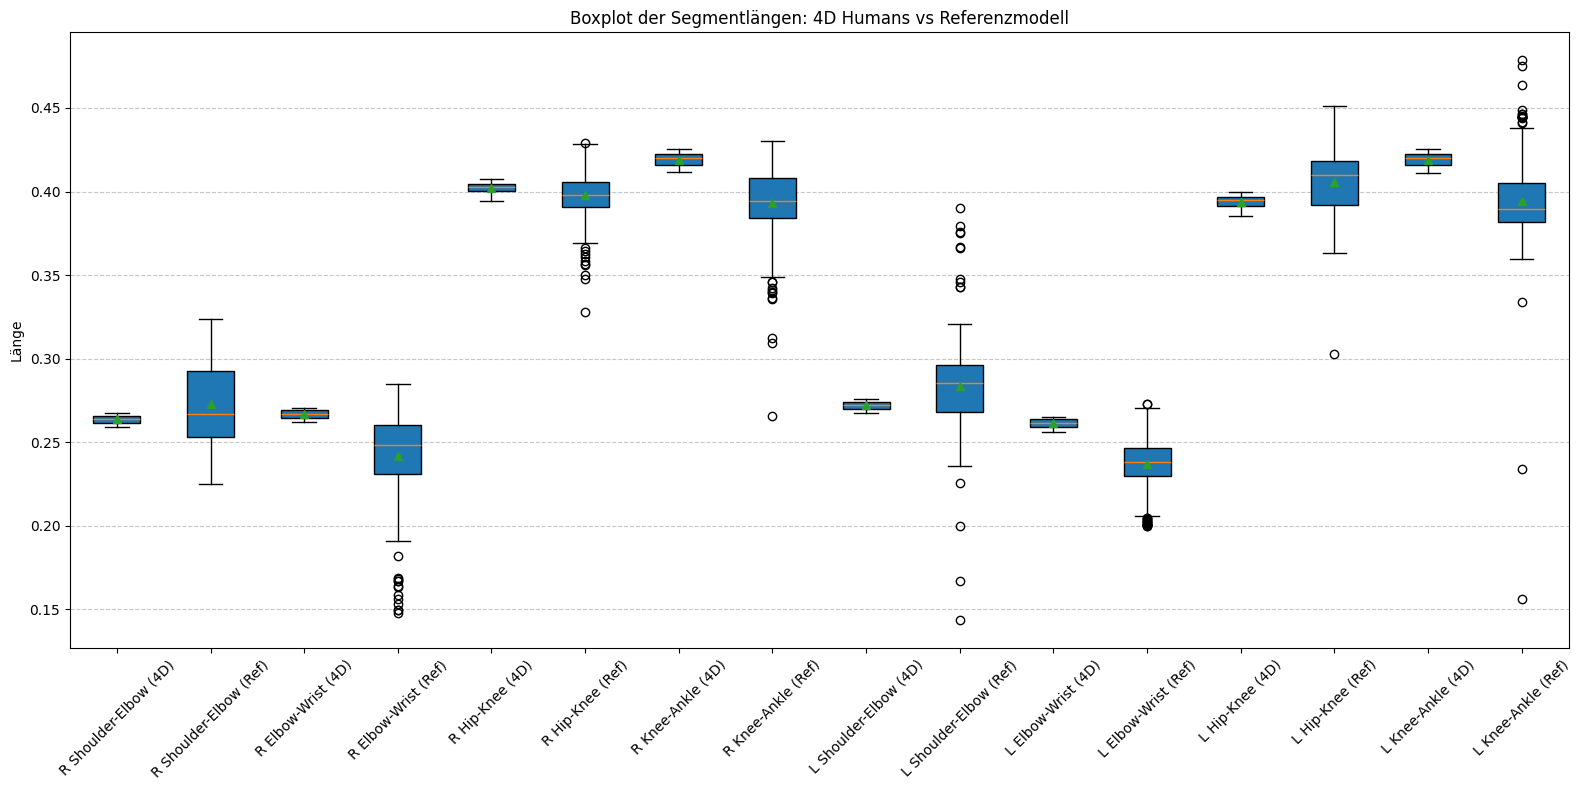

In [16]:
import matplotlib.pyplot as plt

# Daten der Segmentlängen (4D Humans und Referenzmodell)
data = [
    r_shoulder_ellbow, r_shoulder_ellbow_ref,  # Right Shoulder-Elbow
    r_ellbow_wrist, r_ellbow_wrist_ref,        # Right Elbow-Wrist
    r_hip_knee, r_hip_knee_ref,                # Right Hip-Knee
    r_knee_ankle, r_knee_ankle_ref,            # Right Knee-Ankle
    l_shoulder_ellbow, l_shoulder_ellbow_ref,  # Left Shoulder-Elbow
    l_ellbow_wrist, l_ellbow_wrist_ref,        # Left Elbow-Wrist
    l_hip_knee, l_hip_knee_ref,                # Left Hip-Knee
    l_knee_ankle, l_knee_ankle_ref             # Left Knee-Ankle
]

# Labels entsprechend 4D Humans und Referenzmodell
labels = [
    "R Shoulder-Elbow (4D)", "R Shoulder-Elbow (Ref)",
    "R Elbow-Wrist (4D)", "R Elbow-Wrist (Ref)",
    "R Hip-Knee (4D)", "R Hip-Knee (Ref)",
    "R Knee-Ankle (4D)", "R Knee-Ankle (Ref)",
    "L Shoulder-Elbow (4D)", "L Shoulder-Elbow (Ref)",
    "L Elbow-Wrist (4D)", "L Elbow-Wrist (Ref)",
    "L Hip-Knee (4D)", "L Hip-Knee (Ref)",
    "L Knee-Ankle (4D)", "L Knee-Ankle (Ref)"
]

# Boxplot erstellen
plt.figure(figsize=(16, 8))
plt.boxplot(data, patch_artist=True, showmeans=True, labels=labels)

# Plot-Details
plt.title("Boxplot der Segmentlängen: 4D Humans vs Referenzmodell")
plt.ylabel("Länge")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Plot anzeigen
plt.tight_layout()
plt.show()


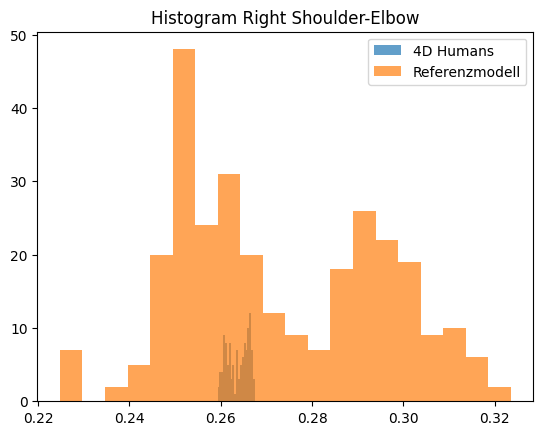

In [17]:
# Histogramm zeigt an, wie die einzelnen Datenpunkte verteilt sind - bei 4D Human sind die Werte sehr einheitlich mit wenig Streuung, während das Referenzmodell eine größere Streuung aufweist
plt.hist(r_shoulder_ellbow, bins=20, alpha=0.7, label="4D Humans")
plt.hist(r_shoulder_ellbow_ref, bins=20, alpha=0.7, label="Referenzmodell")
plt.legend()
plt.title("Histogram Right Shoulder-Elbow")
plt.show()


In [18]:
from typing_extensions import dataclass_transform
# Hier wird der COM berechnet

HAND_FOREARM_SCALE_FACTOR = 0.75

# Definiere die Segmente und relative Faktoren als Dictionary
segments = {
    "head_and_neck": {"points": (43, 40), "factor": 0.567}, # 43 ist Head, 40 ist Thorax
    "torso": {"points": (40, 8), "factor": 0.562}, # 40 ist Thorax, 8 ist Mid Hip
    "upper_arm_right": {"points": (2, 3), "factor": 0.564},  # 2 ist rechte Schulter, 3 ist rechter Ellbogen
    "upper_arm_left": {"points": (5, 6), "factor": 0.564},  # 5 ist linke Schulter, 6 ist linker Ellbogen
    "lower_arm_right": {"points": (3, 4), "factor": 0.57}, # 3 ist rechter Ellbogen, 4 ist rechtes Handgelenk
    "lower_arm_left": {"points": (6, 7), "factor": 0.57}, # 6 ist linker Ellbogen, 7 ist linkes Handgelenk
    "hand_right": {"factor": 0.468}, # Faktor ist hier 46.8, weil wir bei der Berechnung später bei der Wrist anfangen und die Länge des Ellbogens hinzuaddieren, hier also in die andere Richtung gehen als sonst
    "hand_left": {"factor": 0.468},
    "thigh_right": {"points": (9, 10), "factor": 0.567},  # 9 ist rechte Hüfte, 10 ist rechtes Knie
    "thigh_left": {"points": (12, 13), "factor": 0.567}, # 12 ist linke Hüfte, 13 ist linkes Knie
    "calf_right": {"points": (10, 11), "factor": 0.567}, # 10 ist rechtes Knie, 11 ist rechtes Ankle
    "calf_left": {"points": (13, 14), "factor": 0.567}, # 13 ist linkes Knie, 14 ist linkes Ankle
    "foot_right": {"points": (11, 22), "factor": 0.5}, # 11 ist rechtes Ankle, 22 ist großer Zeh rechts
    "foot_left": {"points": (14, 19), "factor": 0.5} # 14 ist linkes Ankle, 19 ist großer Zeh links
}


com_of_segments = {}

for i, frame in enumerate(list(result.keys())):
  com_of_segment = {}
  for segment, data in segments.items():
    if (segment == "hand_right"):
      com_position = np.array(result[frame]["3d_joints"][0][4]) + (
      (np.array(result[frame]["3d_joints"][0][4]) - np.array(result[frame]["3d_joints"][0][3]))
      * HAND_FOREARM_SCALE_FACTOR
      ) * data["factor"]
      com_of_segment[segment] = com_position
    elif segment == "hand_left":
      com_position = np.array(result[frame]["3d_joints"][0][7]) + (
      (np.array(result[frame]["3d_joints"][0][7]) - np.array(result[frame]["3d_joints"][0][6]))
      * HAND_FOREARM_SCALE_FACTOR
      ) * data["factor"]
      com_of_segment[segment] = com_position
    else:
      point_higher, point_lower = data["points"]
      com_position = np.array(result[frame]["3d_joints"][0][point_lower]) + ((np.array(result[frame]["3d_joints"][0][point_higher]) - np.array(result[frame]["3d_joints"][0][point_lower])) * data["factor"])
      com_of_segment[segment] = com_position


  com_of_segments[i] = com_of_segment


for i in range(3):
  print(com_of_segments[i]["head_and_neck"], "Head and Neck COM")

for i in range(3):
    print(com_of_segments[i]["lower_arm_right"], "Lower Arm Right COM")

for i in range(3):
  print(com_of_segments[i]["hand_right"], "Hand Right COM")



[ 0.09194668 -0.7722711  -0.27621657] Head and Neck COM
[ 0.09169395 -0.7715338  -0.27297097] Head and Neck COM
[ 0.08792531 -0.77454865 -0.27055484] Head and Neck COM
[-0.3711899  -0.4516481  -0.14260155] Lower Arm Right COM
[-0.36540994 -0.44705814 -0.1366562 ] Lower Arm Right COM
[-0.36704326 -0.4479955  -0.13333759] Lower Arm Right COM
[-0.52513474 -0.3335177  -0.29375967] Hand Right COM
[-0.5208394  -0.33156535 -0.28774476] Hand Right COM
[-0.52147126 -0.3296596  -0.28119877] Hand Right COM


In [19]:
relative_masses = {
    "head_and_neck": 0.082,  # Beispiel aus Tabelle Hall
    "torso": 0.4684,
    "upper_arm_right": 0.0325,
    "upper_arm_left": 0.0325,
    "lower_arm_right": 0.0196,  # Unterarmgewicht, basierend auf Literaturwerten
    "lower_arm_left": 0.0196,
    "hand_right": 0.0061,  # Handgewicht, basierend auf Literaturwerten
    "hand_left": 0.0061,
    "thigh_right": 0.105,
    "thigh_left": 0.105,
    "calf_right": 0.0475,
    "calf_left": 0.0475,
    "foot_right": 0.0143,
    "foot_left": 0.0143
}


# Liste, die die COMs für alle Frames speichert
COM_xyz_values = {}

for frame in com_of_segments:
  COM_xyz = np.sum([
    np.array(com_of_segments[frame][segment]) * relative_masses[segment]
    for segment in relative_masses.keys()
  ], axis=0)
  COM_xyz_values[frame] = COM_xyz

print(COM_xyz_values)


{0: array([ 0.04153949, -0.2959132 , -0.10362449], dtype=float32), 1: array([ 0.0403835 , -0.2938769 , -0.10000588], dtype=float32), 2: array([ 0.03755197, -0.29733688, -0.09969928], dtype=float32), 3: array([ 0.03678393, -0.29743358, -0.10215095], dtype=float32), 4: array([ 0.03347517, -0.29970765, -0.10669276], dtype=float32), 5: array([ 0.02993865, -0.30194458, -0.10736226], dtype=float32), 6: array([ 0.02950811, -0.30069336, -0.10726541], dtype=float32), 7: array([ 0.02503376, -0.29666358, -0.11104409], dtype=float32), 8: array([ 0.023225  , -0.2982809 , -0.11139157], dtype=float32), 9: array([ 0.02063569, -0.2929655 , -0.11836599], dtype=float32), 10: array([ 0.01956142, -0.29410776, -0.11868991], dtype=float32), 11: array([ 0.01199607, -0.28701925, -0.12288789], dtype=float32), 12: array([ 0.00751375, -0.2907509 , -0.12292959], dtype=float32), 13: array([ 0.00361334, -0.29020044, -0.12455121], dtype=float32), 14: array([-0.00441076, -0.2761854 , -0.14085104], dtype=float32), 15: 

In [20]:
r_ankle = {}
l_ankle = {}
center_ankle = {}

for i, frame in enumerate(list(result.keys())):
  r_ankle[i] = result[frame]["3d_joints"][0][11]
  l_ankle[i] = result[frame]["3d_joints"][0][14]
  center_ankle[i] = (result[frame]["3d_joints"][0][11] + result[frame]["3d_joints"][0][14]) / 2

print(len(r_ankle))
print(len(COM_xyz_values))


117
117


In [21]:
COM_to_ground = {}

for i in COM_xyz_values:
  distance = np.linalg.norm(COM_xyz_values[i] - center_ankle[i])
  COM_to_ground[i] = distance

print(COM_to_ground)

{0: 0.83516055, 1: 0.83531225, 2: 0.8258441, 3: 0.8233454, 4: 0.8134174, 5: 0.808589, 6: 0.809546, 7: 0.8108446, 8: 0.8079058, 9: 0.80322814, 10: 0.80321217, 11: 0.7997785, 12: 0.788425, 13: 0.7929602, 14: 0.78522795, 15: 0.7817862, 16: 0.7795192, 17: 0.7715101, 18: 0.7714118, 19: 0.7654959, 20: 0.7735648, 21: 0.7695321, 22: 0.7670833, 23: 0.7636223, 24: 0.7623254, 25: 0.75666046, 26: 0.7539136, 27: 0.75270075, 28: 0.75509053, 29: 0.75143194, 30: 0.75414115, 31: 0.7570532, 32: 0.76489687, 33: 0.7735289, 34: 0.7897625, 35: 0.7994213, 36: 0.8149826, 37: 0.82652134, 38: 0.8428307, 39: 0.8455673, 40: 0.8630697, 41: 0.87122834, 42: 0.8809966, 43: 0.8800359, 44: 0.8854804, 45: 0.8947362, 46: 0.889527, 47: 0.9010812, 48: 0.90366524, 49: 0.90048194, 50: 0.90168905, 51: 0.8974404, 52: 0.89560395, 53: 0.8942573, 54: 0.88930565, 55: 0.88446933, 56: 0.8838185, 57: 0.88569283, 58: 0.88442343, 59: 0.8735657, 60: 0.86955655, 61: 0.86682963, 62: 0.8604068, 63: 0.8600429, 64: 0.86103797, 65: 0.8538127,

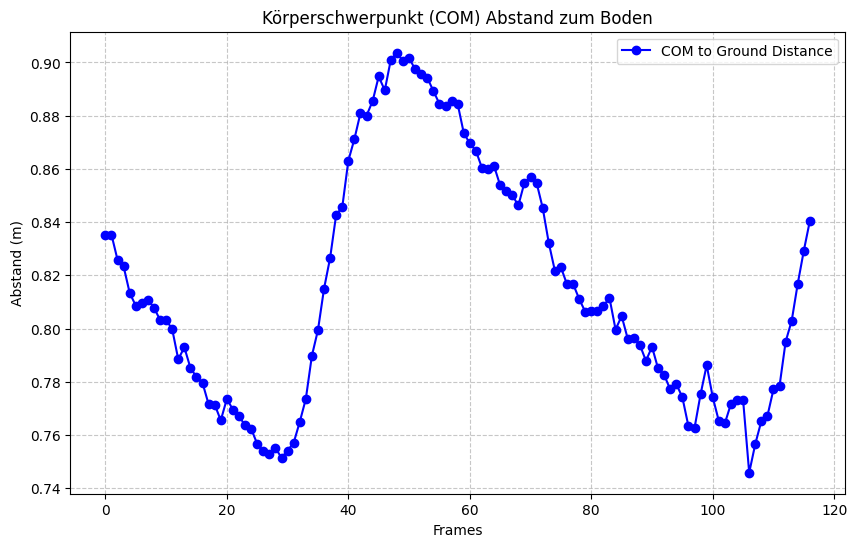

In [22]:
import matplotlib.pyplot as plt

# COM_to_ground-Daten, die du bereits berechnet hast
frames = list(COM_to_ground.keys())
distances = list(COM_to_ground.values())

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(frames, distances, marker='o', linestyle='-', color='b', label="COM to Ground Distance")
plt.title("Körperschwerpunkt (COM) Abstand zum Boden")
plt.xlabel("Frames")
plt.ylabel("Abstand (m)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()


In [25]:
# Hier wird das Feature Kniewinkel für jeden Frame berechnet
r_hip_num = 9
r_knee_num = 10
r_ankle_num = 11
r_shoulder_num = 2
l_hip_num = 12
l_knee_num = 13
l_ankle_num = 14
l_shoulder_num = 5

knee_angles_right = {}
knee_angles_left = {}

for i, frame in enumerate(list(result.keys())):
  vector_right_hip_knee = result[frame]['3d_joints'][0][r_knee_num] - result[frame]['3d_joints'][0][r_hip_num]
  vector_left_hip_knee = result[frame]['3d_joints'][0][l_knee_num] - result[frame]['3d_joints'][0][l_hip_num]
  vector_right_knee_ankle = result[frame]['3d_joints'][0][r_ankle_num] - result[frame]['3d_joints'][0][r_knee_num]
  vector_left_knee_ankle = result[frame]['3d_joints'][0][l_ankle_num] - result[frame]['3d_joints'][0][l_knee_num]

  right_leg_dot_product = np.dot(vector_right_hip_knee, vector_right_knee_ankle)
  left_leg_dot_product = np.dot(vector_left_hip_knee, vector_left_knee_ankle)

  right_hip_knee_length = np.linalg.norm(vector_right_hip_knee)
  left_hip_knee_length = np.linalg.norm(vector_left_hip_knee)
  right_knee_ankle_length = np.linalg.norm(vector_right_knee_ankle)
  left_knee_ankle_length = np.linalg.norm(vector_left_knee_ankle)


  knee_angle_right = np.degrees(np.arccos(right_leg_dot_product / (right_hip_knee_length * right_knee_ankle_length)))
  knee_angle_left = np.degrees(np.arccos(left_leg_dot_product / (left_hip_knee_length * left_knee_ankle_length)))

  knee_angles_right[i] = knee_angle_right
  knee_angles_left[i] = knee_angle_left


for i in range(5):
  print(knee_angles_right)


{0: 40.84227, 1: 41.973206, 2: 46.86987, 3: 47.376663, 4: 49.918045, 5: 51.678543, 6: 50.820187, 7: 49.04827, 8: 48.258812, 9: 48.435028, 10: 49.838074, 11: 49.48597, 12: 54.425312, 13: 54.043686, 14: 50.954998, 15: 53.506886, 16: 56.381557, 17: 54.334164, 18: 54.814735, 19: 56.371414, 20: 54.72461, 21: 56.457844, 22: 56.17979, 23: 58.377308, 24: 58.04186, 25: 58.902565, 26: 60.71873, 27: 59.92236, 28: 61.4739, 29: 63.10216, 30: 63.166767, 31: 62.922096, 32: 63.19191, 33: 61.500896, 34: 59.666588, 35: 58.013638, 36: 54.50339, 37: 53.438923, 38: 49.18715, 39: 48.89138, 40: 43.4758, 41: 39.517, 42: 37.079933, 43: 33.593414, 44: 29.587498, 45: 26.593208, 46: 23.769955, 47: 26.768496, 48: 25.66087, 49: 23.984716, 50: 24.30616, 51: 23.880774, 52: 23.201101, 53: 23.701902, 54: 29.347485, 55: 29.093716, 56: 28.776756, 57: 26.35002, 58: 26.911762, 59: 25.732872, 60: 24.35519, 61: 23.237299, 62: 26.628218, 63: 25.127874, 64: 24.582829, 65: 25.053017, 66: 24.857733, 67: 24.667017, 68: 25.654608,

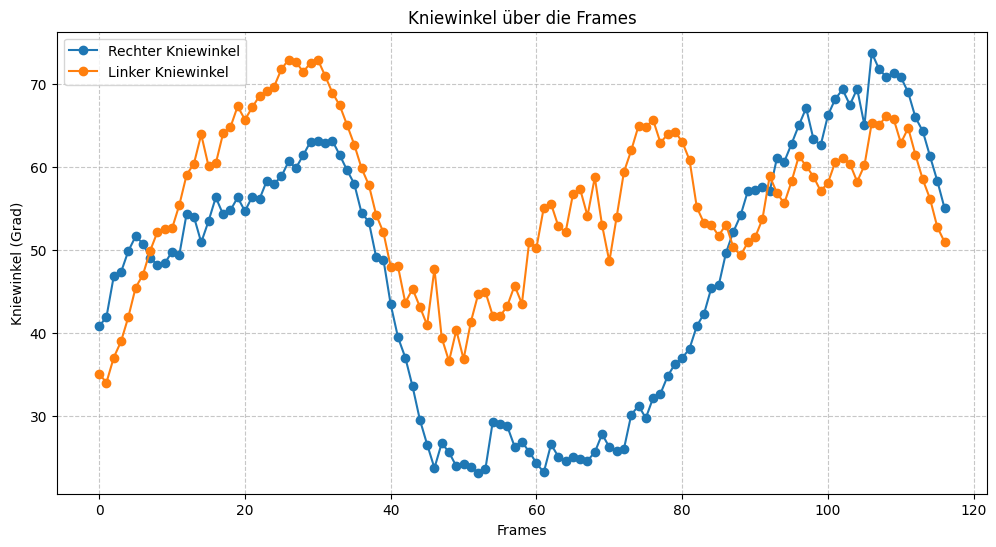

In [27]:
import matplotlib.pyplot as plt

# Frames extrahieren
frames = list(knee_angles_right.keys())

# Kniewinkel extrahieren
right_knee_angles = [knee_angles_right[frame] for frame in frames]
left_knee_angles = [knee_angles_left[frame] for frame in frames]


# Plot erstellen
plt.figure(figsize=(12, 6))

# Kniewinkel (rechts) plotten
plt.plot(frames, right_knee_angles, label="Rechter Kniewinkel", linestyle='-', marker='o')

# Kniewinkel (links) plotten
plt.plot(frames, left_knee_angles, label="Linker Kniewinkel", linestyle='-', marker='o')

# Plot-Details
plt.title("Kniewinkel über die Frames")
plt.xlabel("Frames")
plt.ylabel("Kniewinkel (Grad)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [ ]:
#exemplarische Darstellung des rechten Knies

import matplotlib.pyplot as plt

x_coords = [result[frame]['3d_joints'][0][r_knee_num][0] for frame in result.keys()]
y_coords = [result[frame]['3d_joints'][0][r_knee_num][1] for frame in result.keys()]
z_coords = [result[frame]['3d_joints'][0][r_knee_num][2] for frame in result.keys()]

plt.figure(figsize=(12, 6))
plt.plot(x_coords, label="x-Koordinate")
plt.plot(y_coords, label="y-Koordinate")
plt.plot(z_coords, label="z-Koordinate")
plt.title("Bewegung des rechten Knies")
plt.xlabel("Frames")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.show()

# x-Achse: Die Bewegung des Knies entlang der x-Achse ist logisch, da der Fahrer nach rechts und links fährt. Die starke Veränderung in den Werten passt zu einer Schwungbewegung.
# y-Achse: Diese sollte stabil bleiben, da das Knie (wie du sagst) nicht groß um die y-Achse rotiert. Die minimalen Änderungen könnten durch Tracking-Rauschen entstehen.
# z-Achse: Leichte Schwankungen in z sind plausibel, da das Knie aufgrund von Hoch- und Tiefbewegungen während des Fahrens minimal variiert.

In [ ]:
# Hier wird der Winkel zwischen den Gelenkspunkten und der y-Achse berechnet

z_vector = np.array([0, 0, 1])  # Z-Vektor für die Berechnung
angles_z = {}

for i, frame in enumerate(list(result.keys())):
    # Dictionary für die Winkel eines Frames
    angle_dic = {}

    # Gelenkpunkte des aktuellen Frames
    r_knee = result[frame]['3d_joints'][0][r_knee_num]
    l_knee = result[frame]['3d_joints'][0][l_knee_num]
    r_shoulder = result[frame]['3d_joints'][0][r_shoulder_num]
    l_shoulder = result[frame]['3d_joints'][0][l_shoulder_num]
    r_ankle = result[frame]['3d_joints'][0][r_ankle_num]
    l_ankle = result[frame]['3d_joints'][0][l_ankle_num]
    r_hip = result[frame]['3d_joints'][0][r_hip_num]
    l_hip = result[frame]['3d_joints'][0][l_hip_num]

    # Berechnung der Winkel zur z-Achse für jeden Gelenkpunkt
    angle_dic["angle_z_r_knee"] = np.degrees(np.arccos(np.dot(r_knee, z_vector) / (np.linalg.norm(r_knee) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_l_knee"] = np.degrees(np.arccos(np.dot(l_knee, z_vector) / (np.linalg.norm(l_knee) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_r_shoulder"] = np.degrees(np.arccos(np.dot(r_shoulder, z_vector) / (np.linalg.norm(r_shoulder) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_l_shoulder"] = np.degrees(np.arccos(np.dot(l_shoulder, z_vector) / (np.linalg.norm(l_shoulder) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_r_ankle"] = np.degrees(np.arccos(np.dot(r_ankle, z_vector) / (np.linalg.norm(r_ankle) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_l_ankle"] = np.degrees(np.arccos(np.dot(l_ankle, z_vector) / (np.linalg.norm(l_ankle) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_r_hip"] = np.degrees(np.arccos(np.dot(r_hip, z_vector) / (np.linalg.norm(r_hip) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_l_hip"] = np.degrees(np.arccos(np.dot(l_hip, z_vector) / (np.linalg.norm(l_hip) * np.linalg.norm(z_vector))))

    # Speichern des Frame-Dictionaries im übergeordneten Dictionary
    angles_z[i] = angle_dic

# Ausgabe des finalen Dictionaries
print(angles_z[0])


In [ ]:
# Hier wird der Winkel zwischen den Gelenkspunkten und der y-Achse berechnet

z_vector = np.array([1, 0, 0])  # Z-Vektor für die Berechnung
angles_x = {}

for i, frame in enumerate(list(result.keys())):
    # Dictionary für die Winkel eines Frames
    angle_dic = {}

    # Gelenkpunkte des aktuellen Frames
    r_knee = result[frame]['3d_joints'][0][r_knee_num]
    l_knee = result[frame]['3d_joints'][0][l_knee_num]
    r_shoulder = result[frame]['3d_joints'][0][r_shoulder_num]
    l_shoulder = result[frame]['3d_joints'][0][l_shoulder_num]
    r_ankle = result[frame]['3d_joints'][0][r_ankle_num]
    l_ankle = result[frame]['3d_joints'][0][l_ankle_num]
    r_hip = result[frame]['3d_joints'][0][r_hip_num]
    l_hip = result[frame]['3d_joints'][0][l_hip_num]

    # Berechnung der Winkel zur z-Achse für jeden Gelenkpunkt
    angle_dic["angle_z_r_knee"] = np.degrees(np.arccos(np.dot(r_knee, z_vector) / (np.linalg.norm(r_knee) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_l_knee"] = np.degrees(np.arccos(np.dot(l_knee, z_vector) / (np.linalg.norm(l_knee) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_r_shoulder"] = np.degrees(np.arccos(np.dot(r_shoulder, z_vector) / (np.linalg.norm(r_shoulder) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_l_shoulder"] = np.degrees(np.arccos(np.dot(l_shoulder, z_vector) / (np.linalg.norm(l_shoulder) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_r_ankle"] = np.degrees(np.arccos(np.dot(r_ankle, z_vector) / (np.linalg.norm(r_ankle) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_l_ankle"] = np.degrees(np.arccos(np.dot(l_ankle, z_vector) / (np.linalg.norm(l_ankle) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_r_hip"] = np.degrees(np.arccos(np.dot(r_hip, z_vector) / (np.linalg.norm(r_hip) * np.linalg.norm(z_vector))))
    angle_dic["angle_z_l_hip"] = np.degrees(np.arccos(np.dot(l_hip, z_vector) / (np.linalg.norm(l_hip) * np.linalg.norm(z_vector))))

    # Speichern des Frame-Dictionaries im übergeordneten Dictionary
    angles_x[i] = angle_dic

# Ausgabe des finalen Dictionaries
print(angles_x[0])


In [ ]:
import matplotlib.pyplot as plt

def plot_right_angles(angles, axis):
    """
    Plottet die Winkel der rechten Körperteile über alle Frames.

    Parameter:
    - angles (dict): Ein Dictionary, bei dem die Schlüssel die Frame-Nummern sind
                     und die Werte wiederum Dictionaries mit Winkelinformationen enthalten.
    """
    # Sortiere die Frames für eine geordnete Darstellung
    sorted_frames = sorted(angles.keys())

    # Identifiziere alle Winkel-Keys für die rechten Körperteile
    right_angle_keys = [key for key in angles[0].keys() if key.startswith('angle_z_r_')]

    # Initialisiere ein Dictionary, um die Winkelwerte zu speichern
    angle_values = {key: [] for key in right_angle_keys}

    # Sammle die Winkelwerte für jeden Frame
    for frame in sorted_frames:
        for key in right_angle_keys:
            angle_values[key].append(angles[frame][key])

    # Erstelle das Plot-Fenster
    plt.figure(figsize=(12, 6))

    # Plotte jeden Winkel als eigene Linie
    for key in right_angle_keys:
        plt.plot(sorted_frames, angle_values[key], marker='o', linestyle='-', label=key)

    # Beschrifte die Achsen und füge einen Titel hinzu
    plt.xlabel('Frames')
    plt.ylabel('Winkel (in Grad)')
    plt.title(f'{axis}-Winkel der rechten Körperteile über Frames')

    # Füge eine Legende hinzu
    plt.legend()

    # Füge ein Gitter hinzu für bessere Lesbarkeit
    plt.grid(True, linestyle='--', alpha=0.7)

    # Zeige das Diagramm an
    plt.show()

# Beispielhafte Nutzung der Funktion
# Stelle sicher, dass dein 'angles'-Dictionary bereits definiert und gefüllt ist
# plot_right_angles(angles)
plot_right_angles(angles_z, "z")




In [ ]:
r_heel_num = 24
l_heel_num = 21

lower_leg_angles = {}


z_vector = np.array([0, 0, 1])
y_vector = np.array([0, 1, 0])
x_vector = np.array([1, 0, 0])

for i, frame in enumerate(list(result.keys())):
  lower_leg_angle = {}

  r_knee = result[frame]['3d_joints'][0][r_knee_num]
  l_knee = result[frame]['3d_joints'][0][l_knee_num]
  r_heel = result[frame]['3d_joints'][0][r_heel_num]
  l_heel = result[frame]['3d_joints'][0][l_heel_num]
  right_heel_knee_vector = r_knee - r_heel
  left_heel_knee_vector = l_knee - l_heel

  r_lower_leg_angle_x = np.degrees(np.arccos(np.dot(right_heel_knee_vector, x_vector) / (np.linalg.norm(right_heel_knee_vector) * np.linalg.norm(x_vector))))
  l_lower_leg_angle_x = np.degrees(np.arccos(np.dot(left_heel_knee_vector, x_vector) / (np.linalg.norm(left_heel_knee_vector) * np.linalg.norm(x_vector))))

  r_lower_leg_angle_y = np.degrees(np.arccos(np.dot(right_heel_knee_vector, y_vector) / (np.linalg.norm(right_heel_knee_vector) * np.linalg.norm(y_vector))))
  l_lower_leg_angle_y = np.degrees(np.arccos(np.dot(left_heel_knee_vector, y_vector) / (np.linalg.norm(left_heel_knee_vector) * np.linalg.norm(y_vector))))

  r_lower_leg_angle_z = np.degrees(np.arccos(np.dot(right_heel_knee_vector, z_vector) / (np.linalg.norm(right_heel_knee_vector) * np.linalg.norm(z_vector))))
  l_lower_leg_angle_z = np.degrees(np.arccos(np.dot(left_heel_knee_vector, z_vector) / (np.linalg.norm(left_heel_knee_vector) * np.linalg.norm(z_vector))))

  lower_leg_angle["r_lower_leg_angle_x"] = r_lower_leg_angle_x
  lower_leg_angle["l_lower_leg_angle_x"] = l_lower_leg_angle_x
  lower_leg_angle["r_lower_leg_angle_y"] = r_lower_leg_angle_y
  lower_leg_angle["l_lower_leg_angle_y"] = l_lower_leg_angle_y
  lower_leg_angle["r_lower_leg_angle_z"] = r_lower_leg_angle_z
  lower_leg_angle["l_lower_leg_angle_z"] = l_lower_leg_angle_z

  lower_leg_angles[i] = lower_leg_angle


print(lower_leg_angles[0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lower_leg_angles(lower_leg_angles):
    """
    Plottet die Winkel der Unterschenkel (rechts und links) zur x-, y- und z-Achse über alle Frames.

    Parameter:
    - lower_leg_angles (dict): Dictionary mit Frame-Nummern als Schlüsseln und
                               Dictionaries der Winkel als Werte.
    """
    frames = sorted(lower_leg_angles.keys())

    # Initialisiere Listen für jede Winkelart
    r_angle_x = []
    l_angle_x = []
    r_angle_y = []
    l_angle_y = []
    r_angle_z = []
    l_angle_z = []

    for frame in frames:
        angles = lower_leg_angles[frame]
        r_angle_x.append(angles.get("r_lower_leg_angle_x", np.nan))
        l_angle_x.append(angles.get("l_lower_leg_angle_x", np.nan))
        r_angle_y.append(angles.get("r_lower_leg_angle_y", np.nan))
        l_angle_y.append(angles.get("l_lower_leg_angle_y", np.nan))
        r_angle_z.append(angles.get("r_lower_leg_angle_z", np.nan))
        l_angle_z.append(angles.get("l_lower_leg_angle_z", np.nan))

    plt.figure(figsize=(14, 7))

    # Plot für rechte Unterschenkel
    plt.plot(frames, r_angle_x, label='Rechts - X-Achse', marker='o')
    plt.plot(frames, r_angle_y, label='Rechts - Y-Achse', marker='o')
    plt.plot(frames, r_angle_z, label='Rechts - Z-Achse', marker='o')

    # Plot für linke Unterschenkel
    plt.plot(frames, l_angle_x, label='Links - X-Achse', marker='s')
    plt.plot(frames, l_angle_y, label='Links - Y-Achse', marker='s')
    plt.plot(frames, l_angle_z, label='Links - Z-Achse', marker='s')

    plt.xlabel('Frames')
    plt.ylabel('Winkel (°)')
    plt.title('Unterschenkelwinkel zur x-, y- und z-Achse über Frames')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Beispielhafte Nutzung der Funktion
# Stelle sicher, dass dein 'lower_leg_angles'-Dictionary bereits definiert und gefüllt ist
# plot_lower_leg_angles(lower_leg_angles)

plot_lower_leg_angles(lower_leg_angles)


In [ ]:
COM_angles = {}

for i, frame in enumerate(list(result.keys())):
    COM_angle = {}

    # Berechne den Vektor vom Knöchel-Mittelpunkt zum COM
    ground_to_COM_vector = np.array(COM_xyz_values[i]) - np.array(center_ankle[i])

    # Berechne die Winkel zur x-, y- und z-Achse
    COM_x_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, x_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(x_vector))))
    COM_y_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, y_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(y_vector))))
    COM_z_rotation = np.degrees(np.arccos(np.dot(ground_to_COM_vector, z_vector) / (np.linalg.norm(ground_to_COM_vector) * np.linalg.norm(z_vector))))

    COM_angle["COM_x_rotation"] = COM_x_rotation
    COM_angle["COM_y_rotation"] = COM_y_rotation
    COM_angle["COM_z_rotation"] = COM_z_rotation

    COM_angles[i] = COM_angle

print(COM_angles[0])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_COM_angles(COM_angles):
    """
    Plottet die COM-Winkel zur x-, y- und z-Achse über alle Frames.

    Parameter:
    - COM_angles (dict): Dictionary mit Frame-Nummern als Schlüsseln und
                         Dictionaries der Winkel als Werte.
                         Beispiel:
                         {
                             0: {"COM_x_rotation": 30.0, "COM_y_rotation": 45.0, "COM_z_rotation": 60.0},
                             1: {"COM_x_rotation": 32.0, "COM_y_rotation": 46.0, "COM_z_rotation": 61.0},
                             ...
                         }
    """
    frames = sorted(COM_angles.keys())

    # Listen der Winkelwerte
    COM_x = [COM_angles[frame].get("COM_x_rotation", np.nan) for frame in frames]
    COM_y = [COM_angles[frame].get("COM_y_rotation", np.nan) for frame in frames]
    COM_z = [COM_angles[frame].get("COM_z_rotation", np.nan) for frame in frames]

    plt.figure(figsize=(12, 6))

    # Plot für jede Achse
    plt.plot(frames, COM_x, label='COM X Rotation', marker='o')
    plt.plot(frames, COM_y, label='COM Y Rotation', marker='s')
    plt.plot(frames, COM_z, label='COM Z Rotation', marker='^')

    # Achsenbeschriftungen und Titel
    plt.xlabel('Frames')
    plt.ylabel('Winkel (°)')
    plt.title('COM Winkel zu den Achsen über Frames')

    # Legende und Gitter
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Beispielhafte Nutzung der Funktion
# Stelle sicher, dass dein 'COM_angles'-Dictionary bereits definiert und gefüllt ist
plot_COM_angles(COM_angles)
